In [22]:
import os
import pandas as pd
import yfinance as yf

symbol = "AAPL"
start = "2018-01-01"
end = "2023-12-31"
budget = 5000
cache_dir = "data"

from pathlib import Path
cache_path = Path(cache_dir) / f"{symbol}_{start}_to_{end}.csv"
Path(cache_dir).mkdir(exist_ok=True)

if cache_path.exists():
    os.remove(cache_path)
    print("Deleted old cache:", cache_path)
else:
    print("No cache to delete:", cache_path)

No cache to delete: data\AAPL_2018-01-01_to_2023-12-31.csv


In [23]:
df_raw = yf.download(symbol, start=start, end=end, auto_adjust=False, progress=False, group_by="column")

# flatten MultiIndex if yfinance returns it
if isinstance(df_raw.columns, pd.MultiIndex):
    df_raw.columns = df_raw.columns.get_level_values(0)

df_raw.index = pd.to_datetime(df_raw.index)
df_raw.index.name = "Date"

# ensure Close numeric
df_raw["Close"] = pd.to_numeric(df_raw["Close"], errors="coerce")

# save clean csv
df_raw.reset_index().to_csv(cache_path, index=False)

print("Downloaded rows:", df_raw.shape[0])
print("Columns:", list(df_raw.columns))
df_raw.head()

Downloaded rows: 1509
Columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2018-01-02,40.304184,43.064999,43.075001,42.314999,42.540001,102223600
2018-01-03,40.297153,43.057499,43.637501,42.990002,43.132500,118071600
2018-01-04,40.484337,43.257500,43.367500,43.020000,43.134998,89738400
2018-01-05,40.945267,43.750000,43.842499,43.262501,43.360001,94640000
2018-01-08,40.793179,43.587502,43.902500,43.482498,43.587502,82271200


In [24]:
df_before = pd.read_csv(cache_path, parse_dates=["Date"]).set_index("Date")

print("=== BEFORE CLEANUP ===")
print("Rows:", df_before.shape[0])
print("Duplicate dates:", df_before.index.duplicated().sum())
print("NaNs per column:\n", df_before.isna().sum())
display(df_before.head(3))

df_after = df_before[~df_before.index.duplicated(keep="first")].copy()
df_after = df_after.ffill().dropna()

print("\n=== AFTER CLEANUP ===")
print("Rows:", df_after.shape[0])
print("Duplicate dates:", df_after.index.duplicated().sum())
print("NaNs per column:\n", df_after.isna().sum())
display(df_after.head(3))

=== BEFORE CLEANUP ===
Rows: 1509
Duplicate dates: 0
NaNs per column:
 Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2018-01-02,40.304184,43.064999,43.075001,42.314999,42.540001,102223600
2018-01-03,40.297153,43.057499,43.637501,42.990002,43.132500,118071600
2018-01-04,40.484337,43.257500,43.367500,43.020000,43.134998,89738400



=== AFTER CLEANUP ===
Rows: 1509
Duplicate dates: 0
NaNs per column:
 Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2018-01-02,40.304184,43.064999,43.075001,42.314999,42.540001,102223600
2018-01-03,40.297153,43.057499,43.637501,42.990002,43.132500,118071600
2018-01-04,40.484337,43.257500,43.367500,43.020000,43.134998,89738400


In [25]:
df_after["MA50"] = df_after["Close"].rolling(50).mean()
df_after["MA200"] = df_after["Close"].rolling(200).mean()
df_after = df_after.dropna()


df_after["golden_cross"] = ((df_after["MA50"] > df_after["MA200"]) & (df_after["MA50"].shift(1) <= df_after["MA200"].shift(1))).astype(bool)
df_after["death_cross"]  = ((df_after["MA50"] < df_after["MA200"]) & (df_after["MA50"].shift(1) >= df_after["MA200"].shift(1))).astype(bool)

print("Golden crosses:", int(df_after["golden_cross"].sum()))
print("Death crosses:", int(df_after["death_cross"].sum()))

cash = budget
shares = 0
entry_price = None
entry_date = None
trades = []

for i in range(len(df_after)):
    date = df_after.index[i]
    price = float(df_after["Close"].iloc[i])

    golden = bool(df_after["golden_cross"].iloc[i])
    death  = bool(df_after["death_cross"].iloc[i])

    if golden and shares == 0:
        qty = int(cash // price)
        if qty > 0:
            shares = qty
            cash -= shares * price
            entry_price = price
            entry_date = date

    elif death and shares > 0:
        cash += shares * price
        pnl = (price - entry_price) * shares
        trades.append([entry_date, entry_price, date, price, shares, round(pnl, 2), False])
        shares = 0
        entry_price = None
        entry_date = None


if shares > 0:
    last_date = df_after.index[-1]
    last_price = float(df_after["Close"].iloc[-1])
    cash += shares * last_price
    pnl = (last_price - entry_price) * shares
    trades.append([entry_date, entry_price, last_date, last_price, shares, round(pnl, 2), True])

trades_df = pd.DataFrame(trades, columns=["EntryDate","EntryPrice","ExitDate","ExitPrice","Shares","PnL","ForcedExit"])

print("\n=== TRADES ===")
display(trades_df)

total_pnl = trades_df["PnL"].sum() if len(trades_df) else 0.0
final_value = cash
ret_pct = ((final_value - budget) / budget) * 100

print("\n=== SUMMARY ===")
print("Initial Budget:", budget)
print("Final Value:", round(final_value, 2))
print("Total PnL:", round(total_pnl, 2))
print("Return %:", round(ret_pct, 2))

Golden crosses: 3
Death crosses: 3

=== TRADES ===


,EntryDate,EntryPrice,ExitDate,ExitPrice,Shares,PnL,ForcedExit
0,2019-05-07,50.715000,2022-06-03,145.380005,98,9277.17,False
1,2022-09-28,149.839996,2022-09-30,138.199997,95,-1105.80,False
2,2023-03-23,158.929993,2023-12-29,192.529999,82,2755.20,True



=== SUMMARY ===
Initial Budget: 5000
Final Value: 15926.57
Total PnL: 10926.57
Return %: 218.53


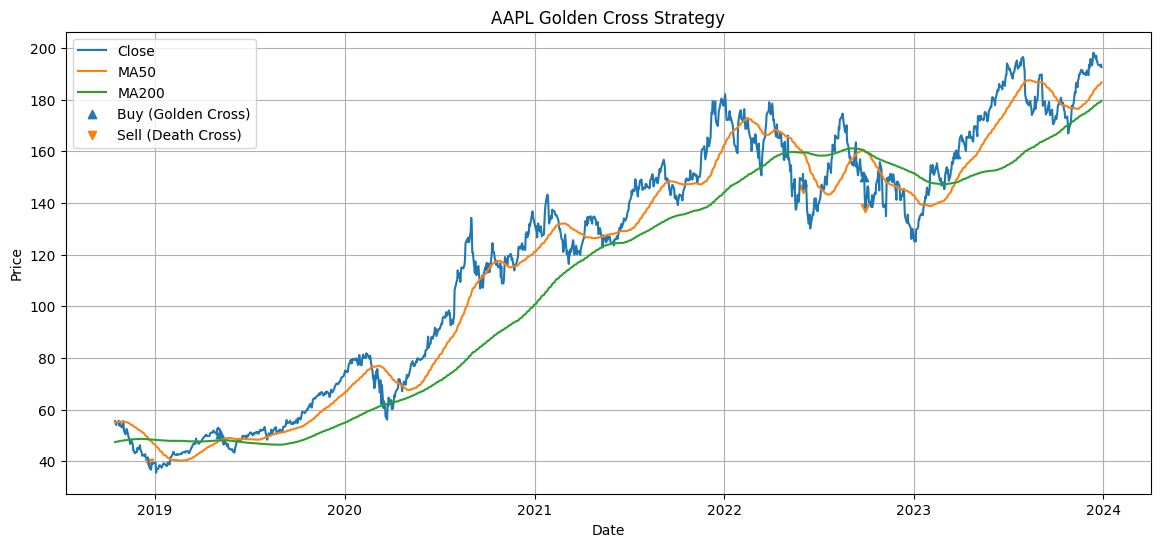

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.plot(df_after.index, df_after["Close"], label="Close")
plt.plot(df_after.index, df_after["MA50"], label="MA50")
plt.plot(df_after.index, df_after["MA200"], label="MA200")


buys = df_after[df_after["golden_cross"]]
sells = df_after[df_after["death_cross"]]

plt.scatter(buys.index, buys["Close"], marker="^", label="Buy (Golden Cross)")
plt.scatter(sells.index, sells["Close"], marker="v", label="Sell (Death Cross)")

plt.title(f"{symbol} Golden Cross Strategy")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()